In [1]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Tokenization classes."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import re
import unicodedata
import six
import tensorflow as tf
from tqdm import tqdm_notebook


def validate_case_matches_checkpoint(do_lower_case, init_checkpoint):
  """Checks whether the casing config is consistent with the checkpoint name."""

  # The casing has to be passed in by the user and there is no explicit check
  # as to whether it matches the checkpoint. The casing information probably
  # should have been stored in the bert_config.json file, but it's not, so
  # we have to heuristically detect it to validate.

  if not init_checkpoint:
    return

  m = re.match("^.*?([A-Za-z0-9_-]+)/bert_model.ckpt", init_checkpoint)
  if m is None:
    return

  model_name = m.group(1)

  lower_models = [
      "uncased_L-24_H-1024_A-16", "uncased_L-12_H-768_A-12",
      "multilingual_L-12_H-768_A-12", "chinese_L-12_H-768_A-12"
  ]

  cased_models = [
      "cased_L-12_H-768_A-12", "cased_L-24_H-1024_A-16",
      "multi_cased_L-12_H-768_A-12"
  ]

  is_bad_config = False
  if model_name in lower_models and not do_lower_case:
    is_bad_config = True
    actual_flag = "False"
    case_name = "lowercased"
    opposite_flag = "True"

  if model_name in cased_models and do_lower_case:
    is_bad_config = True
    actual_flag = "True"
    case_name = "cased"
    opposite_flag = "False"

  if is_bad_config:
    raise ValueError(
        "You passed in `--do_lower_case=%s` with `--init_checkpoint=%s`. "
        "However, `%s` seems to be a %s model, so you "
        "should pass in `--do_lower_case=%s` so that the fine-tuning matches "
        "how the model was pre-training. If this error is wrong, please "
        "just comment out this check." % (actual_flag, init_checkpoint,
                                          model_name, case_name, opposite_flag))


def convert_to_unicode(text):
  """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text.decode("utf-8", "ignore")
    elif isinstance(text, unicode):
      return text
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")


def printable_text(text):
  """Returns text encoded in a way suitable for print or `tf.logging`."""

  # These functions want `str` for both Python2 and Python3, but in one case
  # it's a Unicode string and in the other it's a byte string.
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text
    elif isinstance(text, unicode):
      return text.encode("utf-8")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")


def load_vocab(vocab_file):
  """Loads a vocabulary file into a dictionary."""
  vocab = collections.OrderedDict()
  index = 0
  with tf.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = convert_to_unicode(reader.readline())
      if not token:
        break
      token = token.strip()
      vocab[token] = index
      index += 1
  return vocab


def convert_by_vocab(vocab, items):
  """Converts a sequence of [tokens|ids] using the vocab."""
  output = []
  for item in items:
    output.append(vocab[item])
  return output


def convert_tokens_to_ids(vocab, tokens):
  return convert_by_vocab(vocab, tokens)


def convert_ids_to_tokens(inv_vocab, ids):
  return convert_by_vocab(inv_vocab, ids)


def whitespace_tokenize(text):
  """Runs basic whitespace cleaning and splitting on a piece of text."""
  text = text.strip()
  if not text:
    return []
  tokens = text.split()
  return tokens


class FullTokenizer(object):
  """Runs end-to-end tokenziation."""

  def __init__(self, vocab_file, do_lower_case=True):
    self.vocab = load_vocab(vocab_file)
    self.inv_vocab = {v: k for k, v in self.vocab.items()}
    self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
    self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(sub_token)

    return split_tokens

  def convert_tokens_to_ids(self, tokens):
    return convert_by_vocab(self.vocab, tokens)

  def convert_ids_to_tokens(self, ids):
    return convert_by_vocab(self.inv_vocab, ids)


class BasicTokenizer(object):
  """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

  def __init__(self, do_lower_case=True):
    """Constructs a BasicTokenizer.
    Args:
      do_lower_case: Whether to lower case the input.
    """
    self.do_lower_case = do_lower_case

  def tokenize(self, text):
    """Tokenizes a piece of text."""
    text = convert_to_unicode(text)
    text = self._clean_text(text)

    # This was added on November 1st, 2018 for the multilingual and Chinese
    # models. This is also applied to the English models now, but it doesn't
    # matter since the English models were not trained on any Chinese data
    # and generally don't have any Chinese data in them (there are Chinese
    # characters in the vocabulary because Wikipedia does have some Chinese
    # words in the English Wikipedia.).
    text = self._tokenize_chinese_chars(text)

    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
      if self.do_lower_case:
        token = token.lower()
        token = self._run_strip_accents(token)
      split_tokens.extend(self._run_split_on_punc(token))

    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

  def _run_strip_accents(self, text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
      cat = unicodedata.category(char)
      if cat == "Mn":
        continue
      output.append(char)
    return "".join(output)

  def _run_split_on_punc(self, text):
    """Splits punctuation on a piece of text."""
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
      char = chars[i]
      if _is_punctuation(char):
        output.append([char])
        start_new_word = True
      else:
        if start_new_word:
          output.append([])
        start_new_word = False
        output[-1].append(char)
      i += 1

    return ["".join(x) for x in output]

  def _tokenize_chinese_chars(self, text):
    """Adds whitespace around any CJK character."""
    output = []
    for char in text:
      cp = ord(char)
      if self._is_chinese_char(cp):
        output.append(" ")
        output.append(char)
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)

  def _is_chinese_char(self, cp):
    """Checks whether CP is the codepoint of a CJK character."""
    # This defines a "chinese character" as anything in the CJK Unicode block:
    #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
    #
    # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
    # despite its name. The modern Korean Hangul alphabet is a different block,
    # as is Japanese Hiragana and Katakana. Those alphabets are used to write
    # space-separated words, so they are not treated specially and handled
    # like the all of the other languages.
    if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
        (cp >= 0x3400 and cp <= 0x4DBF) or  #
        (cp >= 0x20000 and cp <= 0x2A6DF) or  #
        (cp >= 0x2A700 and cp <= 0x2B73F) or  #
        (cp >= 0x2B740 and cp <= 0x2B81F) or  #
        (cp >= 0x2B820 and cp <= 0x2CEAF) or
        (cp >= 0xF900 and cp <= 0xFAFF) or  #
        (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
      return True

    return False

  def _clean_text(self, text):
    """Performs invalid character removal and whitespace cleanup on text."""
    output = []
    for char in text:
      cp = ord(char)
      if cp == 0 or cp == 0xfffd or _is_control(char):
        continue
      if _is_whitespace(char):
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)


class WordpieceTokenizer(object):
  """Runs WordPiece tokenziation."""

  def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
    self.vocab = vocab
    self.unk_token = unk_token
    self.max_input_chars_per_word = max_input_chars_per_word

  def tokenize(self, text):
    """Tokenizes a piece of text into its word pieces.
    This uses a greedy longest-match-first algorithm to perform tokenization
    using the given vocabulary.
    For example:
      input = "unaffable"
      output = ["un", "##aff", "##able"]
    Args:
      text: A single token or whitespace separated tokens. This should have
        already been passed through `BasicTokenizer.
    Returns:
      A list of wordpiece tokens.
    """

    text = convert_to_unicode(text)

    output_tokens = []
    for token in whitespace_tokenize(text):
      chars = list(token)
      if len(chars) > self.max_input_chars_per_word:
        output_tokens.append(self.unk_token)
        continue

      is_bad = False
      start = 0
      sub_tokens = []
      while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
          substr = "".join(chars[start:end])
          if start > 0:
            substr = "##" + substr
          if substr in self.vocab:
            cur_substr = substr
            break
          end -= 1
        if cur_substr is None:
          is_bad = True
          break
        sub_tokens.append(cur_substr)
        start = end

      if is_bad:
        output_tokens.append(self.unk_token)
      else:
        output_tokens.extend(sub_tokens)
    return output_tokens


def _is_whitespace(char):
  """Checks whether `chars` is a whitespace character."""
  # \t, \n, and \r are technically contorl characters but we treat them
  # as whitespace since they are generally considered as such.
  if char == " " or char == "\t" or char == "\n" or char == "\r":
    return True
  cat = unicodedata.category(char)
  if cat == "Zs":
    return True
  return False


def _is_control(char):
  """Checks whether `chars` is a control character."""
  # These are technically control characters but we count them as whitespace
  # characters.
  if char == "\t" or char == "\n" or char == "\r":
    return False
  cat = unicodedata.category(char)
  if cat.startswith("C"):
    return True
  return False


def _is_punctuation(char):
  """Checks whether `chars` is a punctuation character."""
  cp = ord(char)
  # We treat all non-letter/number ASCII as punctuation.
  # Characters such as "^", "$", and "`" are not in the Unicode
  # Punctuation class but we treat them as punctuation anyways, for
  # consistency.
  if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
      (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
    return True
  cat = unicodedata.category(char)
  if cat.startswith("P"):
    return True
  return False

In [2]:
class BertLayer(tf.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )

        trainable_vars = self.bert.variables

        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [3]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text, char_encode, label):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text = text
        self.char_encode = char_encode
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, label, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.char_encode, example.label if label else None

def convert_examples_to_features(tokenizer, examples, max_seq_length=256, need_label=True):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, char_encodeings, labels = [], [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, char_encodeing, label = convert_single_example(
            tokenizer, example, need_label, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        char_encodeings.append(char_encodeing)
        if need_label:
            labels.append(label)
    if need_label:
        return (
            np.array(input_ids),
            np.array(input_masks),
            np.array(segment_ids),
            np.array(char_encodeings),
            np.array(labels).reshape(-1, 1),
        )
    return (
            np.array(input_ids),
            np.array(input_masks),
            np.array(segment_ids),
            np.array(char_encodeings)
        )

def convert_text_to_examples(df, label=True):
    """Create InputExamples"""
    InputExamples = []
    texts = df.sentence.values
    labels = df.label.values if label else None
    char_encodes = df.char_encode.values
    if label:
        for text, label, char_encode in zip(texts, labels, char_encodes):
            InputExamples.append(
                InputExample(guid=None, text=text, char_encode=char_encode, label=label)
            )
    else:
        for text, char_encode in zip(texts, char_encodes):
            InputExamples.append(
                InputExample(guid=None, text=text, char_encode=char_encode, label=None)
            )
    return InputExamples

In [4]:
def pronoun_coref_pos(sentence, pronoun, pronoun_loc, noun, noun_loc, is_coref=None, max_len=1400):
    char_encode = [0] * max_len
    char_encode = np.array(char_encode)
    char_encode[pronoun_loc:pronoun_loc+len(pronoun)] = 1
    char_encode[noun_loc:noun_loc+len(noun)] = 1
    if is_coref is not None:
        return [sentence, char_encode, 1 if is_coref else 0]
    return [sentence, char_encode]

def input_processing(df, label=True):
    result = pd.DataFrame()
    if label:
        a_sentence, a_encode, a_output = list(zip(*df.apply(lambda x: pronoun_coref_pos(x['Text'], x["Pronoun"], x["Pronoun-offset"], x["A"], x["A-offset"], x["A-coref"]), axis=1)))
        b_sentence, b_encode, b_output = list(zip(*df.apply(lambda x: pronoun_coref_pos(x['Text'], x["Pronoun"], x["Pronoun-offset"], x["B"], x["B-offset"], x["B-coref"]), axis=1)))
        sentence = list(a_sentence) + list(b_sentence)
        char_encode = list(a_encode) + list(b_encode)
        labels = list(a_output) + list(b_output)
        result["sentence"] = sentence
        result["char_encode"] = char_encode
        result["label"] = labels
    else:
        a_sentence, a_encode = list(zip(*df.apply(lambda x: pronoun_coref_pos(x['Text'], x["Pronoun"], x["Pronoun-offset"], x["A"], x["A-offset"]), axis=1)))
        b_sentence, b_encode = list(zip(*df.apply(lambda x: pronoun_coref_pos(x['Text'], x["Pronoun"], x["Pronoun-offset"], x["B"], x["B-offset"]), axis=1)))
        sentence = list(a_sentence) + list(b_sentence)
        char_encode = list(a_encode) + list(b_encode)
        result["sentence"] = sentence
        result["char_encode"] = char_encode
    return result

In [5]:
# Build model
def build_model(max_seq_length, max_char_seq_length, 
                embedding_size, vocab_size, char_input_size ,embedding_weights): 
    
    # character input
#     character_input = tf.keras.layers.Input(shape=(char_input_size,), name="Character_input")
#     embedding_layer = tf.keras.layers.Embedding(vocab_size+1, embedding_size, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5), name="Character_embedding")
# #     embed_char_out = embedding_layer(character_input)
#     embed_char_out = tf.keras.layers.TimeDistributed(embedding_layer)(character_input)
#     dropout = tf.keras.layers.Dropout(self.dropout)(embed_char_out)
#     # CNN
#     conv1d_out = tf.keras.layers.TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
#     maxpool_out = tf.keras.layers.TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
#     char = tf.keras.layers.TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
#     char = tf.keras.layers.Dropout(self.dropout)(char)
        
#     #sentence vector inputs
#     in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
#     in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
#     in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
#     bert_inputs = [in_id, in_mask, in_segment]
    
#     bert_output = tf.keras.layers.BertLayer(n_fine_tune_layers=3)(bert_inputs)
    
#     #positional input
#     position_input = tf.keras.layers.Input(shape=(max_char_seq_length,), dtype='int32', name='position_input')
#     # concat & BLSTM
#     output = tf.keras.layers.concatenate([bert_output, position_input, char])
#     output = tf.keras.layers.Bidirectional(LSTM(self.lstm_state_size, 
#                                 return_sequences=True, 
#                                 dropout=self.dropout,                        # on input to each LSTM block
#                                 recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
#                                ), name="BLSTM")(output)
#     pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
#     model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
#     return model
    dropout_recurrent = 0.25  # not specified in paper, 0.25 recommended
    lstm_state_size = 200     # paper: 275
    conv_size = 3             # paper: 3
    learning_rate = 0.0105    # paper 0.0105
    optimizer = tf.keras.optimizers.Nadam()  
    character_input = tf.keras.layers.Input(shape=(char_input_size,), name="Character_input")
    # embedding_layer = tf.keras.layers.Embedding(vocab_size+1, embedding_size, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5))
    #     embed_char_out = embedding_layer(character_input)
    embedding_layer = tf.keras.layers.Embedding(vocab_size+1, embedding_size, input_length=max_char_seq_length, weights=[embedding_weights])

    embed_char_out = embedding_layer(character_input)

    embed_char_out = tf.keras.layers.Dropout(0.5)(embed_char_out)
    # CNN
    conv1d_out = tf.keras.layers.Conv1D(kernel_size=conv_size, filters=30, padding='same', activation='tanh', strides=1)(embed_char_out)
    maxpool_out = tf.keras.layers.MaxPooling1D(52)(conv1d_out)
    char_output = tf.keras.layers.Flatten()(maxpool_out)
    char_output = tf.keras.layers.Dropout(0.5)(char_output)

     #sentence vector inputs
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    bert_output = BertLayer(n_fine_tune_layers=3)(bert_inputs)

     #positional input
    position_input = tf.keras.layers.Input(shape=(max_char_seq_length,), dtype='float32', name='position_input')
    # concat & BLSTM
    # position_input_cast = tf.cast(position_input,tf.float32) 

    output = tf.keras.layers.concatenate([bert_output, char_output, position_input])

    x = tf.keras.layers.Dense(1024)(output)
    x = tf.keras.layers.LeakyReLU(0.3)(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.LeakyReLU(0.3)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU(0.3)(x)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[character_input, in_id, in_mask, in_segment, position_input], outputs=pred)
    return model

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# !git clone https://github.com/google-research-datasets/gap-coreference.git
print(os.listdir("../input/gendered-pronoun-resolution"))
print(os.listdir("../input/gap-coreference"))
# Any results you write to the current directory are saved as output.
import spacy
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import collections
import six
from tensorflow.keras import backend as K
# Any results you write to the current directory are saved as output.

['test_stage_1.tsv', 'sample_submission_stage_1.csv']
['gap-development.tsv', 'gap-test.tsv', 'gap-validation.tsv']


W0327 08:06:19.631456 140327398888832 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [7]:
GAP_FOLDER = "../input/gap-coreference/"
TEST_FOLDER = "../input/gendered-pronoun-resolution/"

In [8]:
gap_train_df = pd.read_csv(GAP_FOLDER+"gap-test.tsv", delimiter="\t")
gap_valid_df = pd.read_csv(GAP_FOLDER+"gap-validation.tsv", delimiter="\t")
test_df = pd.read_csv(TEST_FOLDER+"test_stage_1.tsv" ,delimiter="\t")
train_df = pd.concat([gap_train_df, gap_valid_df])

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
K.set_session(sess)
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 400

In [10]:
tokenizer = create_tokenizer_from_hub_module()

Instructions for updating:
Colocations handled automatically by placer.


W0327 08:07:10.195723 140327398888832 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0327 08:07:12.198482 140327398888832 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [11]:
all_text = np.concatenate((gap_train_df.Text.values, gap_valid_df.Text.values, test_df.Text.values), axis=0)
max_char_seq_length = 1400
char_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None, char_level=True, oov_token='UNK')
char_tokenizer.fit_on_texts(all_text)

In [23]:
vocab_size = len(char_tokenizer.word_index)
embedding_weights = []
embedding_weights.append(np.zeros(vocab_size))
for char, i in char_tokenizer.word_index.items():
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)
embedding_size = embedding_weights.shape[1]

In [13]:
train_df = input_processing(gap_train_df)
train_df.head()

,sentence,char_encode,label
0,Upon their acceptance into the Kontinental Hoc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"Between the years 1979-1981, River won four lo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,Though his emigration from the country has aff...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"At the trial, Pisciotta said: ``Those who have...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,It is about a pair of United States Navy shore...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [14]:
valid_df = input_processing(gap_valid_df)
valid_df.head()

,sentence,char_encode,label
0,He admitted making four trips to China and pla...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"Kathleen Nott was born in Camberwell, London. ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"When she returns to her hotel room, a Liberian...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"On 19 March 2007, during a campaign appearance...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"By this time, Karen Blixen had separated from ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [15]:
train_examples = convert_text_to_examples(train_df)
test_examples = convert_text_to_examples(valid_df)

In [16]:
(train_input_ids, train_input_masks, train_segment_ids, train_char_encode, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_char_encode, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

In [17]:
train_char_vec = char_tokenizer.texts_to_sequences(train_df.sentence)
train_char_vec = tf.keras.preprocessing.sequence.pad_sequences(train_char_vec, maxlen=max_char_seq_length, padding='post')
test_char_vec = char_tokenizer.texts_to_sequences(valid_df.sentence)
test_char_vec = tf.keras.preprocessing.sequence.pad_sequences(test_char_vec, maxlen=max_char_seq_length, padding='post')

In [25]:
embedding_size

61

In [26]:
model = build_model(max_seq_length=max_seq_length, max_char_seq_length=max_char_seq_length, 
                        embedding_size=embedding_size, vocab_size=vocab_size, char_input_size=max_char_seq_length ,embedding_weights=embedding_weights)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0327 08:11:43.202158 140327398888832 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0327 08:11:44.064185 140327398888832 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0327 08:11:45.941169 140327398888832 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [27]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Character_input (InputLayer)    (None, 1400)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1400, 61)     3782        Character_input[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1400, 61)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1400, 30)     5520        dropout[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [29]:
weight_path="{}_weights.best.hdf5".format('gender_pronoun_res')

checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=3, verbose=1, mode='auto', 
                                   epsilon=0.001, cooldown=5, min_lr=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

W0327 08:11:58.737298 140327398888832 callbacks.py:1269] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


In [30]:
sess = tf.InteractiveSession()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
K.set_session(sess)
histroy = model.fit(
    [train_char_vec, train_input_ids, train_input_masks, train_segment_ids, train_char_encode], 
    train_labels,
    validation_data=([test_char_vec, test_input_ids, test_input_masks, test_segment_ids, test_char_encode], test_labels),
    epochs=200,
    batch_size=128,
    callbacks=callbacks_list
)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train on 4000 samples, validate on 908 samples
Instructions for updating:
Use tf.cast instead.


W0327 08:12:05.512896 140327398888832 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/2
3968/4000 [============================>.] - ETA: 0s - loss: 0.8280 - acc: 0.5280
Epoch 00001: val_loss improved from inf to 0.69079, saving model to gender_pronoun_res_weights.best.hdf5
4000/4000 [==============================] - 100s 25ms/sample - loss: 0.8271 - acc: 0.5268 - val_loss: 0.6908 - val_acc: 0.5121
Epoch 2/2
3968/4000 [============================>.] - ETA: 0s - loss: 0.6822 - acc: 0.5514
Epoch 00002: val_loss improved from 0.69079 to 0.67740, saving model to gender_pronoun_res_weights.best.hdf5
4000/4000 [==============================] - 93s 23ms/sample - loss: 0.6820 - acc: 0.5515 - val_loss: 0.6774 - val_acc: 0.5705


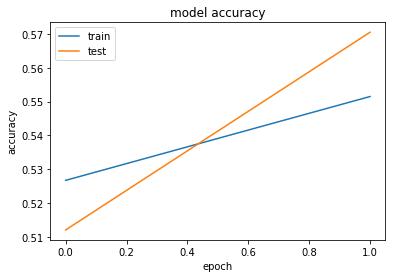

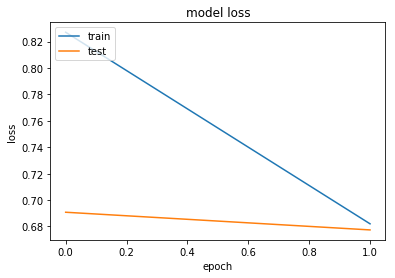

In [31]:
import matplotlib.pyplot as plt
plt.plot(histroy.history['acc'])
plt.plot(histroy.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model.save("gap_model.hdf5")
model.save_weights("gap_model_weights.hdf5")

In [33]:
model.evaluate([test_char_vec, test_input_ids, test_input_masks, test_segment_ids, test_char_encode], test_labels)

908/908 [==============================] - 15s 16ms/sample - loss: 0.6774 - acc: 0.5705


[0.6774042240848626, 0.5704846]

In [34]:
test_data_df = input_processing(test_df, label=False)
test_data_df.head()

,sentence,char_encode
0,Zoe Telford -- played the police officer girlf...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"He grew up in Evanston, Illinois the second ol...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"He had been reelected to Congress, but resigne...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The current members of Crime have also perform...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [35]:
test_data_char_vec = char_tokenizer.texts_to_sequences(test_data_df.sentence)
test_data_char_vec = tf.keras.preprocessing.sequence.pad_sequences(test_data_char_vec, maxlen=max_char_seq_length, padding='post')

In [36]:
test_data = convert_text_to_examples(test_data_df, label=False)

In [37]:
(test_data_input_ids, test_data_input_masks, test_data_segment_ids, test_data_char_encode) = convert_examples_to_features(tokenizer, test_data, max_seq_length=max_seq_length, need_label=False)

In [38]:
y_pred = model.predict([
    test_data_char_vec,
    test_data_input_ids,
    test_data_input_masks,
    test_data_segment_ids,
    test_data_char_encode
], batch_size=256)

In [39]:
a = y_pred[0:2000]
b = y_pred[2000:]

In [40]:
a = a.reshape(2000)
b = b.reshape(2000)

In [41]:
none = np.absolute(1 - (a+b))

In [42]:
sub = pd.DataFrame({
    "ID" : test_df.ID,
    "A" : a,
    "B" : b,
    "NEITHER" : none
})

In [43]:
sub.head()

,ID,A,B,NEITHER
0,development-1,0.527540,0.479936,0.007476
1,development-2,0.451436,0.368527,0.180037
2,development-3,0.443984,0.394854,0.161162
3,development-4,0.505743,0.391635,0.102622
4,development-5,0.356653,0.501825,0.141522


In [44]:
sub.to_csv("submission.csv")